# Spark in action

In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')

In [2]:
sc.version

'2.3.1'

In [3]:
# do something to prove it works
rdd = sc.parallelize(range(1000))
rdd.takeSample(False, 5)

[212, 730, 980, 105, 698]

# Starting with pySpark

## Experimenting with RDD

In [4]:
numbers = range(10)
numbers_rdd = sc.parallelize(numbers)
numbers_rdd

PythonRDD[4] at RDD at PythonRDD.scala:49

In [5]:
numbers_rdd.collect()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
numbers_rdd.take(3)

[0, 1, 2]

In [7]:
import urllib.request
url = "http://www.gutenberg.org/files/100/100-0.txt"
urllib.request.urlretrieve(url, "shakespeare_all.txt")

('shakespeare_all.txt', <http.client.HTTPMessage at 0x7f1c2b7f6eb8>)

In [8]:
sc.textFile("file:////home//jovyan//shakespeare_all.txt").take(6)

['',
 'Project Gutenberg’s The Complete Works of William Shakespeare, by William',
 'Shakespeare',
 '',
 'This eBook is for the use of anyone anywhere in the United States and',
 'most other parts of the world at no cost and with almost no restrictions']

In [9]:
numbers_rdd.saveAsTextFile("file:////home//jovyan//numbers_1_10.txt")

In [10]:
def sq(x):
    return x**2

numbers_rdd.map(sq).collect()

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [11]:
numbers_rdd.map(lambda x: x**2).collect()

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [12]:
numbers_rdd.map(lambda x: x**2).reduce(lambda a,b: a+b)

285

In [13]:
numbers_rdd.map(lambda x: x**2).sum()

285

In [14]:
def tag(x):
    return "even" if x%2==0 else "odd"

numbers_rdd.map(lambda x: (tag(x), x) ).collect()

[('even', 0),
 ('odd', 1),
 ('even', 2),
 ('odd', 3),
 ('even', 4),
 ('odd', 5),
 ('even', 6),
 ('odd', 7),
 ('even', 8),
 ('odd', 9)]

In [15]:
numbers_rdd.map(lambda x: (tag(x), x) ) \
.reduceByKey(lambda a,b: a+b).collect()

[('even', 20), ('odd', 25)]

In [16]:
def emit_feats(line):
    return [("chars", len(line)), \
            ("words", len(line.split())), \
            ("lines", 1)]

print ((sc.textFile("file:////home//jovyan//shakespeare_all.txt")
        .flatMap(emit_feats)
        .reduceByKey(lambda a,b: a+b)
        .collectAsMap()))

{'chars': 5535014, 'words': 959893, 'lines': 149689}


In [17]:
import re
WORD_RE = re.compile(r"[\w']+")
print ((sc.textFile("file:////home//jovyan//shakespeare_all.txt")
        .flatMap(lambda line: [(word.lower(), 1) for word in 
                               WORD_RE.findall(line)])
        .reduceByKey(lambda a,b: a+b)
        .takeOrdered(1, key = lambda x: -x[1])))

[('the', 29998)]


## Sharing variables across cluster nodes

### Broadcast read-only variables

In [18]:
one_hot_encoding = {"M": (1, 0, 0), "F": (0, 1, 0),
                    "U": (0, 0, 1)}

In [19]:
bcast_map = sc.broadcast(one_hot_encoding)

def bcast_map_ohe(x, shared_ohe):
    return shared_ohe[x]

(sc.parallelize(["M", "F", "U", "F", "M", "U"])
     .map(lambda x: bcast_map_ohe(x, bcast_map.value))
     .collect())

[(1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 1, 0), (1, 0, 0), (0, 0, 1)]

In [20]:
bcast_map.unpersist()

### Accumulators write-only variables

In [21]:
import urllib.request
url = "http://gutenberg.pglaf.org/1/6/6/1661/1661.txt"
urllib.request.urlretrieve(url, "sherlock.txt")

('sherlock.txt', <http.client.HTTPMessage at 0x7f1c2b7a5208>)

In [22]:
accum = sc.accumulator(0)

def split_line(line):
    if len(line) == 0:
        accum.add(1)
    return 1

filename = 'file:////home//jovyan//sherlock.txt'

tot_lines = (
    sc.textFile(filename)
    .map(split_line)
    .count())

empty_lines = accum.value

In [23]:
print("In the file there are %d lines" % tot_lines)
print("And %d lines are empty" % empty_lines)

In the file there are 13053 lines
And 2666 lines are empty


### Broadcast and accumulators together – an example


In [24]:
from sklearn.datasets import load_iris
bcast_dataset = sc.broadcast(load_iris())

In [25]:
from pyspark import AccumulatorParam

class ErrorAccumulator(AccumulatorParam):
    
    def zero(self, initialList):
        return initialList
    
    def addInPlace(self, v1, v2):
        if not isinstance(v1, list):
            v1 = [v1]
        if not isinstance(v2, list):
            v2 = [v2]
        return v1 + v2
    
errAccum = sc.accumulator([], ErrorAccumulator())

In [26]:
def apply_classifier(clf, dataset):
    clf_name = clf.__class__.__name__
    X = dataset.value.data
    y = dataset.value.target
    try:
        from sklearn.metrics import accuracy_score
        clf.fit(X, y)
        y_pred = clf.predict(X)
        acc = accuracy_score(y, y_pred)
        return [(clf_name, acc)]
    except Exception as e:
        errAccum.add((clf_name, str(e)))
        return []

In [27]:
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

classifiers = [DummyClassifier('most_frequent'),
               SGDClassifier(),
               PCA(),
               MDS()]

(sc.parallelize(classifiers)
 .flatMap(lambda x: apply_classifier(x, bcast_dataset))
 .collect())

[('DummyClassifier', 0.33333333333333331),
 ('SGDClassifier', 0.60666666666666669)]

In [28]:
print("The errors are:", errAccum.value)

The errors are: [('PCA', "'PCA' object has no attribute 'predict'"), ('MDS', "'MDS' object has no attribute 'predict'")]


In [29]:
bcast_dataset.unpersist()

## Data preprocessing in Spark

In [30]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [31]:
data = """balance,gender,user_id
10.0,,0
1.0,M,1
-0.5,F,2
0.0,F,3
5.0,,4
3.0,M,5
"""
with open("users.csv", "w") as output:
    output.write(data)

In [32]:
df = sqlContext.read.format('com.databricks.spark.csv')\
.options(header='true', inferschema='true').load('users.csv')
df.show()

+-------+------+-------+
|balance|gender|user_id|
+-------+------+-------+
|   10.0|  null|      0|
|    1.0|     M|      1|
|   -0.5|     F|      2|
|    0.0|     F|      3|
|    5.0|  null|      4|
|    3.0|     M|      5|
+-------+------+-------+



In [33]:
df.printSchema()

root
 |-- balance: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- user_id: integer (nullable = true)



In [34]:
(df.filter(df['gender'] != 'null')
 .filter(df['balance'] > 0)
 .select(['balance', 'gender', 'user_id'])
 .show())

+-------+------+-------+
|balance|gender|user_id|
+-------+------+-------+
|    1.0|     M|      1|
|    3.0|     M|      5|
+-------+------+-------+



In [35]:
(df.filter('gender is not null')
 .filter('balance > 0').select("*").show())

+-------+------+-------+
|balance|gender|user_id|
+-------+------+-------+
|    1.0|     M|      1|
|    3.0|     M|      5|
+-------+------+-------+



In [36]:
df.filter('gender is not null and balance > 0').show()

+-------+------+-------+
|balance|gender|user_id|
+-------+------+-------+
|    1.0|     M|      1|
|    3.0|     M|      5|
+-------+------+-------+



## Dealing with missing data

In [37]:
df.na.drop().show()

+-------+------+-------+
|balance|gender|user_id|
+-------+------+-------+
|    1.0|     M|      1|
|   -0.5|     F|      2|
|    0.0|     F|      3|
|    3.0|     M|      5|
+-------+------+-------+



In [38]:
df.na.drop(subset=["gender"]).show()

+-------+------+-------+
|balance|gender|user_id|
+-------+------+-------+
|    1.0|     M|      1|
|   -0.5|     F|      2|
|    0.0|     F|      3|
|    3.0|     M|      5|
+-------+------+-------+



In [39]:
df.na.fill({'gender': "U", 'balance': 0.0}).show()

+-------+------+-------+
|balance|gender|user_id|
+-------+------+-------+
|   10.0|     U|      0|
|    1.0|     M|      1|
|   -0.5|     F|      2|
|    0.0|     F|      3|
|    5.0|     U|      4|
|    3.0|     M|      5|
+-------+------+-------+



## Grouping and creating tables in-memory

In [40]:
(df.na.fill({'gender': "U", 'balance': 0.0})
 .groupBy("gender").avg('balance').show())

+------+------------+
|gender|avg(balance)|
+------+------------+
|     F|       -0.25|
|     M|         2.0|
|     U|         7.5|
+------+------------+



In [41]:
df.registerTempTable("users")

In [42]:
sqlContext.sql("""
SELECT gender, AVG(balance)
FROM users
WHERE gender IS NOT NULL
GROUP BY gender""").show()

+------+------------+
|gender|avg(balance)|
+------+------------+
|     F|       -0.25|
|     M|         2.0|
+------+------------+



In [43]:
type(sqlContext.table("users"))

pyspark.sql.dataframe.DataFrame

In [44]:
sqlContext.table("users").collect()

[Row(balance=10.0, gender=None, user_id=0),
 Row(balance=1.0, gender='M', user_id=1),
 Row(balance=-0.5, gender='F', user_id=2),
 Row(balance=0.0, gender='F', user_id=3),
 Row(balance=5.0, gender=None, user_id=4),
 Row(balance=3.0, gender='M', user_id=5)]

In [45]:
a_row = sqlContext.sql("SELECT * FROM users").first()
a_row

Row(balance=10.0, gender=None, user_id=0)

In [46]:
print(a_row['balance'])
print(a_row.balance)

10.0
10.0


In [47]:
a_row.asDict()

{'balance': 10.0, 'gender': None, 'user_id': 0}

## Writing the preprocessed DataFrame or RDD to disk

In [48]:
(df.na.drop().write
 .save("file:////home//jovyan//complete_users.csv", format='csv'))

In [49]:
!ls -als ./complete_users.json

ls: cannot access './complete_users.json': No such file or directory


In [50]:
sqlContext.sql("""SELECT * FROM 
csv.`file:////home//jovyan//complete_users.csv`""").show()

+----+---+---+
| _c0|_c1|_c2|
+----+---+---+
| 1.0|  M|  1|
|-0.5|  F|  2|
| 0.0|  F|  3|
| 3.0|  M|  5|
+----+---+---+



In [51]:
(df.na.drop().write
 .save("file:////home//jovyan//complete_users.parquet", format='parquet'))

## Working with Spark DataFrames

In [52]:
from pyspark.sql import Row
rdd_gender = \
sc.parallelize([Row(short_gender="M", long_gender="Male"),
                Row(short_gender="F", long_gender="Female")])
(sqlContext.createDataFrame(rdd_gender)
 .registerTempTable("gender_maps"))

sqlContext.table("gender_maps").show()

+-----------+------------+
|long_gender|short_gender|
+-----------+------------+
|       Male|           M|
|     Female|           F|
+-----------+------------+



In [53]:
sqlContext.sql("""
SELECT balance, long_gender, user_id
FROM parquet.`file:////home//jovyan//complete_users.parquet`
JOIN gender_maps ON gender=short_gender""").show()

+-------+-----------+-------+
|balance|long_gender|user_id|
+-------+-----------+-------+
|    3.0|       Male|      5|
|    1.0|       Male|      1|
|    0.0|     Female|      3|
|   -0.5|     Female|      2|
+-------+-----------+-------+



In [54]:
sqlContext.tableNames()

['gender_maps', 'users']

In [55]:
for table in sqlContext.tableNames():
    sqlContext.dropTempTable(table)

# Machine learning with Spark

In [56]:
!mkdir datasets
!rm -rf ./datasets/kdd*
# !wget -q -O datasets/kddtrain.gz \
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz
!wget -q -O datasets/kddtrain.gz \
http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
!wget -q -O datasets/kddtest.gz \
http://kdd.ics.uci.edu/databases/kddcup99/corrected.gz
!wget -q -O datasets/kddnames \
http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
!gunzip datasets/kdd*gz

In [57]:
!head -3 datasets/kddtrain

0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.


In [58]:
with open('datasets/kddnames', 'r') as fh:
    header = [line.split(':')[0]
              for line in fh.read().splitlines()][1:]
    header.append('target')

print("Num features:", len(header)-1)
print("First 10:", header[:10])

Num features: 41
First 10: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot']


In [59]:
train_rdd = sc.textFile('file:////home//jovyan//datasets//kddtrain')
test_rdd = sc.textFile('file:////home//jovyan//datasets//kddtest')

In [60]:
def line_parser(line):
    def piece_parser(piece):
        if "." in piece or piece.isdigit():
            return float(piece)
        else:
            return piece
    return [piece_parser(piece) for piece in line[:-1].split(',')]

train_df = sqlContext.createDataFrame(train_rdd.map(line_parser), header)
test_df = sqlContext.createDataFrame(test_rdd.map(line_parser), header)

In [61]:
print("Train observations:", train_df.count())
print("Test observations:", test_df.count())

Train observations: 494021
Test observations: 311029


In [62]:
train_df.printSchema()

root
 |-- duration: double (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: double (nullable = true)
 |-- dst_bytes: double (nullable = true)
 |-- land: double (nullable = true)
 |-- wrong_fragment: double (nullable = true)
 |-- urgent: double (nullable = true)
 |-- hot: double (nullable = true)
 |-- num_failed_logins: double (nullable = true)
 |-- logged_in: double (nullable = true)
 |-- num_compromised: double (nullable = true)
 |-- root_shell: double (nullable = true)
 |-- su_attempted: double (nullable = true)
 |-- num_root: double (nullable = true)
 |-- num_file_creations: double (nullable = true)
 |-- num_shells: double (nullable = true)
 |-- num_access_files: double (nullable = true)
 |-- num_outbound_cmds: double (nullable = true)
 |-- is_host_login: double (nullable = true)
 |-- is_guest_login: double (nullable = true)
 |-- count: double (nullable = true)
 |-- srv_count: do

## Feature engineering

In [63]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

cols_categorical = ["protocol_type", "service", "flag","target"]
preproc_stages = []
for col in cols_categorical:
    out_col = col + "_cat"
    preproc_stages.append(
        StringIndexer(
            inputCol=col, outputCol=out_col, handleInvalid="skip"))
    
pipeline = Pipeline(stages=preproc_stages)
indexer = pipeline.fit(train_df)
train_num_df = indexer.transform(train_df)
test_num_df = indexer.transform(test_df)

In [64]:
print(pipeline.getStages(), '\n')
print(pipeline)
print(indexer)

[StringIndexer_41b28fee9864db989e89, StringIndexer_44c3a046b204584add71, StringIndexer_4db3ba50ee9f43d00de0, StringIndexer_4eebbc9e848d5c17a169] 

Pipeline_4a73ac67a75beee4e5aa
PipelineModel_4ac5860c272697ad31d1


In [65]:
features_header = set(header) \
- set(cols_categorical) \
| set([c + "_cat" for c in cols_categorical]) \
- set(["target", "target_cat"])
features_header = list(features_header)
print(features_header)
print("Total numerical features:", len(features_header))

['dst_host_rerror_rate', 'num_failed_logins', 'dst_bytes', 'diff_srv_rate', 'srv_diff_host_rate', 'is_guest_login', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'urgent', 'num_file_creations', 'serror_rate', 'is_host_login', 'su_attempted', 'same_srv_rate', 'dst_host_srv_diff_host_rate', 'flag_cat', 'root_shell', 'dst_host_same_srv_rate', 'num_access_files', 'dst_host_srv_count', 'rerror_rate', 'dst_host_srv_rerror_rate', 'src_bytes', 'wrong_fragment', 'num_root', 'dst_host_count', 'logged_in', 'num_outbound_cmds', 'srv_rerror_rate', 'dst_host_diff_srv_rate', 'srv_serror_rate', 'hot', 'count', 'num_shells', 'duration', 'land', 'num_compromised', 'srv_count', 'dst_host_same_src_port_rate', 'service_cat', 'protocol_type_cat']
Total numerical features: 41


In [66]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=features_header,
    outputCol="features")
Xy_train = (assembler
            .transform(train_num_df)
            .select("features", "target_cat"))
Xy_test = (assembler
           .transform(test_num_df)
           .select("features", "target_cat"))

In [67]:
Xy_train.first()

Row(features=SparseVector(41, {2: 5450.0, 13: 1.0, 17: 1.0, 19: 9.0, 22: 181.0, 25: 9.0, 26: 1.0, 32: 8.0, 37: 8.0, 38: 0.11, 39: 2.0, 40: 1.0}), target_cat=2.0)

## Training a learner

In [68]:
from pyspark.ml.classification import RandomForestClassifier

clf = RandomForestClassifier(
    labelCol="target_cat", featuresCol="features",
    maxBins=100, seed=101)
fit_clf = clf.fit(Xy_train)

In [69]:
print(clf)
print(fit_clf)

RandomForestClassifier_454d9d8ad8a3505cc863
RandomForestClassificationModel (uid=RandomForestClassifier_454d9d8ad8a3505cc863) with 20 trees


In [70]:
Xy_pred_train = fit_clf.transform(Xy_train)
Xy_pred_test = fit_clf.transform(Xy_test)
print("First observation after classification stage:")
print(Xy_pred_test.first())

First observation after classification stage:
Row(features=SparseVector(41, {2: 146.0, 13: 1.0, 17: 1.0, 19: 254.0, 22: 105.0, 25: 255.0, 29: 0.01, 32: 1.0, 37: 1.0, 39: 1.0, 40: 2.0}), target_cat=2.0, rawPrediction=DenseVector([0.0228, 0.0086, 19.6396, 0.0139, 0.0116, 0.0242, 0.0235, 0.0753, 0.1372, 0.0187, 0.012, 0.0042, 0.0009, 0.0001, 0.0011, 0.0011, 0.0014, 0.0008, 0.0007, 0.0004, 0.0009, 0.0004, 0.0005]), probability=DenseVector([0.0011, 0.0004, 0.982, 0.0007, 0.0006, 0.0012, 0.0012, 0.0038, 0.0069, 0.0009, 0.0006, 0.0002, 0.0, 0.0, 0.0001, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), prediction=2.0)


## Evaluating a learner's performance

In [71]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="target_cat", 
    predictionCol="prediction", 
    metricName="f1")
f1_train = evaluator.evaluate(Xy_pred_train)
f1_test = evaluator.evaluate(Xy_pred_test)
print("F1-score train set: %0.3f" % f1_train)
print("F1-score test set: %0.3f" % f1_test)

F1-score train set: 0.992
F1-score test set: 0.966


## The power of the ML pipeline

In [72]:
full_stages = preproc_stages + [assembler, clf]
full_pipeline = Pipeline(stages=full_stages)
full_model = full_pipeline.fit(train_df)
predictions = full_model.transform(test_df)
f1_preds = evaluator.evaluate(predictions)
print("F1-score test set: %0.3f" % f1_preds)

F1-score test set: 0.966


In [73]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm):
    cm_normalized = \
    cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(
        cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion matrix')
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

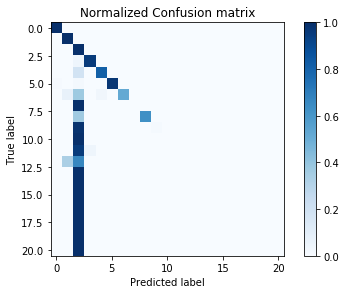

In [74]:
from pyspark.mllib.evaluation import MulticlassMetrics

metrics = MulticlassMetrics(
    predictions.select("prediction", "target_cat").rdd)
conf_matrix = metrics.confusionMatrix().toArray()
plot_confusion_matrix(conf_matrix)

## Manual tuning

In [75]:
train_composition = (train_df.groupBy("target")
                     .count()
                     .rdd
                     .collectAsMap())
train_composition

{'neptune': 107201,
 'satan': 1589,
 'nmap': 231,
 'portsweep': 1040,
 'back': 2203,
 'warezclient': 1020,
 'guess_passwd': 53,
 'normal': 97278,
 'rootkit': 10,
 'perl': 3,
 'buffer_overflow': 30,
 'multihop': 7,
 'ipsweep': 1247,
 'warezmaster': 20,
 'imap': 12,
 'teardrop': 979,
 'spy': 2,
 'land': 21,
 'pod': 264,
 'ftp_write': 8,
 'smurf': 280790,
 'loadmodule': 9,
 'phf': 4}

In [76]:
def set_sample_rate_between_vals(cnt, the_min, the_max):
    if the_min <= cnt <= the_max:
        # no sampling
        return 1
    elif cnt < the_min:
        # Oversampling: return many times the same observation
        return the_min/float(cnt)
    else:
        # Subsampling: sometime don't return it
        return the_max/float(cnt)
    
sample_rates = {k:set_sample_rate_between_vals(v, 1000, 25000) 
                for k,v in train_composition.items()}
sample_rates

{'neptune': 0.23320677978750198,
 'satan': 1,
 'nmap': 4.329004329004329,
 'portsweep': 1,
 'back': 1,
 'warezclient': 1,
 'guess_passwd': 18.867924528301888,
 'normal': 0.2569954152017928,
 'rootkit': 100.0,
 'perl': 333.3333333333333,
 'buffer_overflow': 33.333333333333336,
 'multihop': 142.85714285714286,
 'ipsweep': 1,
 'warezmaster': 50.0,
 'imap': 83.33333333333333,
 'teardrop': 1.0214504596527068,
 'spy': 500.0,
 'land': 47.61904761904762,
 'pod': 3.787878787878788,
 'ftp_write': 125.0,
 'smurf': 0.08903450977598917,
 'loadmodule': 111.11111111111111,
 'phf': 250.0}

In [77]:
bc_sample_rates = sc.broadcast(sample_rates)

def map_and_sample(el, rates):
    rate = rates.value[el['target']]
    if rate > 1:
        return [el]*int(rate)
    else:
        import random
        return [el] if random.random() < rate else []

sampled_train_df = (train_df
                    .rdd
                    .flatMap(
                    lambda x: map_and_sample(x, bc_sample_rates))
                    .toDF()
                    .cache())

In [78]:
sampled_train_df.count()

96358

In [79]:
sampled_train_df.first()

Row(duration=0.0, protocol_type='tcp', service='http', flag='SF', src_bytes=235.0, dst_bytes=1337.0, land=0.0, wrong_fragment=0.0, urgent=0.0, hot=0.0, num_failed_logins=0.0, logged_in=1.0, num_compromised=0.0, root_shell=0.0, su_attempted=0.0, num_root=0.0, num_file_creations=0.0, num_shells=0.0, num_access_files=0.0, num_outbound_cmds=0.0, is_host_login=0.0, is_guest_login=0.0, count=8.0, srv_count=8.0, serror_rate=0.0, srv_serror_rate=0.0, rerror_rate=0.0, srv_rerror_rate=0.0, same_srv_rate=1.0, diff_srv_rate=0.0, srv_diff_host_rate=0.0, dst_host_count=29.0, dst_host_srv_count=29.0, dst_host_same_srv_rate=1.0, dst_host_diff_srv_rate=0.0, dst_host_same_src_port_rate=0.03, dst_host_srv_diff_host_rate=0.0, dst_host_serror_rate=0.0, dst_host_srv_serror_rate=0.0, dst_host_rerror_rate=0.0, dst_host_srv_rerror_rate=0.0, target='normal')

In [80]:
full_model = full_pipeline.fit(sampled_train_df)
predictions = full_model.transform(test_df)
f1_preds = evaluator.evaluate(predictions)
print("F1-score test set: %0.3f" % f1_preds)

F1-score test set: 0.935


In [81]:
clf = RandomForestClassifier(
    numTrees=50, maxBins=100, seed=101,
    labelCol="target_cat", featuresCol="features")
stages = full_pipeline.getStages()[:-1]
stages.append(clf)
refined_pipeline = Pipeline(stages=stages)
refined_model = refined_pipeline.fit(sampled_train_df)
predictions = refined_model.transform(test_df)
f1_preds = evaluator.evaluate(predictions)
print ("F1-score test set: %0.3f" % f1_preds )

F1-score test set: 0.967


## Cross-validation

In [82]:
pipeline_to_clf = Pipeline(
    stages=preproc_stages + [assembler]).fit(sampled_train_df)
train = pipeline_to_clf.transform(sampled_train_df).cache()
test = pipeline_to_clf.transform(test_df)

In [83]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

rf = RandomForestClassifier(
    cacheNodeIds=True, seed=101, labelCol="target_cat",
    featuresCol="features", maxBins=100)
grid = (ParamGridBuilder()
        .addGrid(rf.maxDepth, [3, 6, 9, 12])
        .addGrid(rf.numTrees, [20, 50])
        .build())
cv = CrossValidator(
    estimator=rf, estimatorParamMaps=grid,
    evaluator=evaluator, numFolds=3)
cvModel = cv.fit(train)

In [84]:
predictions = cvModel.transform(test)
f1_preds = evaluator.evaluate(predictions)
print("F1-score test set: %0.3f" % f1_preds)

F1-score test set: 0.970


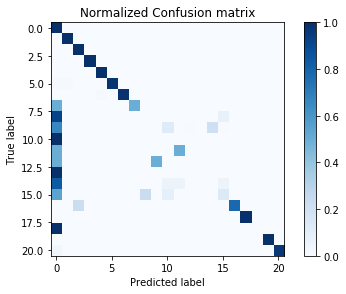

In [85]:
metrics = MulticlassMetrics(
    predictions.select("prediction", "target_cat").rdd)
conf_matrix = metrics.confusionMatrix().toArray()
plot_confusion_matrix(conf_matrix)

## Final cleanup

In [86]:
bc_sample_rates.unpersist()
sampled_train_df.unpersist()
train.unpersist()

DataFrame[duration: double, protocol_type: string, service: string, flag: string, src_bytes: double, dst_bytes: double, land: double, wrong_fragment: double, urgent: double, hot: double, num_failed_logins: double, logged_in: double, num_compromised: double, root_shell: double, su_attempted: double, num_root: double, num_file_creations: double, num_shells: double, num_access_files: double, num_outbound_cmds: double, is_host_login: double, is_guest_login: double, count: double, srv_count: double, serror_rate: double, srv_serror_rate: double, rerror_rate: double, srv_rerror_rate: double, same_srv_rate: double, diff_srv_rate: double, srv_diff_host_rate: double, dst_host_count: double, dst_host_srv_count: double, dst_host_same_srv_rate: double, dst_host_diff_srv_rate: double, dst_host_same_src_port_rate: double, dst_host_srv_diff_host_rate: double, dst_host_serror_rate: double, dst_host_srv_serror_rate: double, dst_host_rerror_rate: double, dst_host_srv_rerror_rate: double, target: string, 